# Tutorial code for single-cell RNA-seq data analysis
# This code includes feature selection, dimensionality reduction, batch correction, clustering, etc
# Fan Zhang
# 2022-05-05

In [148]:
suppressPackageStartupMessages({
    # imports for analyses
    library(symphony)
    library(Seurat)
    library(dplyr)
    library(singlecellmethods)
    library(harmony)
    library(irlba)
    library(gridExtra)
    library(tidyverse)
    library(msigdbr)
    library(parallel)
    library(magrittr)
    
    # imports for figures
    library(viridis)
    library(ggrepel)
    library(ggrastr)
    library(ggpubr)
    library(ggplot2)
    library(ggthemes)
    library(ggpointdensity)
    library(cowplot)
    
    # linear modeling
    library(nlme)
    library(limma)
    library(glmnet)
    library(stringr) 
})

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

meta_colors <- list(
    "cluster" = c(
       "SC-F1" = "#6BAED6",
        "SC-F2" = "#08306B", 
        "SC-F3" = "#DEEBF7",
        "SC-F4" = "grey",
        "SC-T1" = "#8C510A",
        "SC-T2" = "brown",
        "SC-T3" = "#FFFF33",
        "SC-T4" = "#C7EAE5",
        "SC-T5" = "#003C30",
        "SC-T6" = "#35978F", 
        "SC-B1" = "#FCBBA1",
        "SC-B2" = "#CB181D", 
        "SC-B3" = "#67000D",
        "SC-B4" = "#FB9A99",
        "SC-M1" = "#AE017E",
        "SC-M2" = "#F768A1",
        "SC-M3" = "#FDE0EF", 
        "SC-M4" = "#49006A",
        "Centroid" = "grey"
        )
    )

In [4]:
# Functions
FindVariableGenesBatch <- function(exprs_mat, meta_df, genes_exclude = NULL, ngenes_use = 1e3, expr_min = .1) {
    if (!is.null(genes_exclude)) {
        genes_use <- setdiff(row.names(exprs_mat), genes_exclude)
    }
    x_res <- split(meta_df$cell, meta_df$plate) %>% lapply(function(x) {
        FindVariableGenesSeurat(exprs_mat[genes_use, x]) %>% 
            subset(gene.mean >= expr_min) %>% 
            tibble::rownames_to_column("gene") %>% 
            dplyr::arrange(-gene.dispersion) %>%
            head(ngenes_use)
    })
    data.table(Reduce(rbind, x_res))[, .N, by = gene][order(-N)]    
}


FindVariableGenesSeurat <- function (data, x.low.cutoff = 0.1, x.high.cutoff = 8,
                                     y.cutoff = 1, y.high.cutoff = Inf, num.bin = 0,
                                     binning.method = "equal_width", sort.results = TRUE,
                                     display.progress = TRUE, ...)
{
    genes.use <- rownames(data)
    if (class(data) != "dgCMatrix") {
        data <- as(as.matrix(data), "dgCMatrix")
    }
    ## (1) get means and variances
    gene.mean <- FastExpMean(data, display.progress)
    names(gene.mean) <- genes.use
    gene.dispersion <- FastLogVMR(data, display.progress)
    names(gene.dispersion) <- genes.use

    gene.dispersion[is.na(x = gene.dispersion)] <- 0
    gene.mean[is.na(x = gene.mean)] <- 0

    mv.df <- data.frame(gene.mean, gene.dispersion)
    rownames(mv.df) <- rownames(data)

    ## (OPTIONAL) do the binning correction
    if (num.bin > 0) {
      if (binning.method == "equal_width") {
          data_x_bin <- cut(x = gene.mean, breaks = num.bin)
      }
      else if (binning.method == "equal_frequency") {
          data_x_bin <- cut(x = gene.mean, breaks = c(-1, quantile(gene.mean[gene.mean >
              0], probs = seq(0, 1, length.out = num.bin))))
     }
      else {
          stop(paste0("Invalid selection: '", binning.method,
              "' for 'binning.method'."))
      }
      names(x = data_x_bin) <- names(x = gene.mean)
      mean_y <- tapply(X = gene.dispersion, INDEX = data_x_bin,
          FUN = mean)
      sd_y <- tapply(X = gene.dispersion, INDEX = data_x_bin,
          FUN = sd)
      gene.dispersion.scaled <- (gene.dispersion - mean_y[as.numeric(x = data_x_bin)])/sd_y[as.numeric(x = data_x_bin)]
      gene.dispersion.scaled[is.na(x = gene.dispersion.scaled)] <- 0
      ##names(gene.dispersion.scaled) <- names(gene.mean)

      mv.df$gene.dispersion.scaled <- gene.dispersion.scaled
    }

    return(mv.df)
}

environment(FindVariableGenesSeurat) <- asNamespace("Seurat")

ScaleDataSeurat <- function (data.use, margin = 1, scale.max = 10,
                                block.size = 1000) {

    if (margin == 2) data.use %<>% t
    max.block <- ceiling(nrow(data.use)/block.size)

    ## Define data and functions to use in sparse and dense cases
    if (class(data.use) == "dgCMatrix" | class(data.use) == "dgTMatrix") {
        scale_fxn <- function(x) {
            FastSparseRowScale(mat = x, scale = TRUE, center = TRUE,
                               scale_max = scale.max, display_progress = FALSE)
        }
    } else {
        scale_fxn <- function(x) {
            FastRowScale(mat = x, scale = TRUE, center = TRUE,
                               scale_max = scale.max, display_progress = FALSE)
       }
        data.use <- as.matrix(data.use)
    }

    ## Do scaling, at once or in chunks
    if (max.block == 1) {
        scaled.data <- scale_fxn(data.use)
    } else {
        scaled.data <- matrix(NA, nrow(data.use), ncol(data.use))
        for (i in 1:max.block) {
            idx.min <- (block.size * (i - 1))
            idx.max <- min(nrow(data.use), (block.size * i - 1) + 1)
            my.inds <- idx.min:idx.max
            scaled.data[my.inds, ] <- scale_fxn(data.use[my.inds, , drop = F])
        }
    }

    colnames(scaled.data) <- colnames(data.use)
    row.names(scaled.data) <- row.names(data.use)
    scaled.data[is.na(scaled.data)] <- 0
    if (margin == 2) scaled.data %<>% t
    return(scaled.data)
}
environment(ScaleDataSeurat) <- asNamespace("Seurat")


fig.size <- function(height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

SingleFeaturePlotSeurat <- function (data.use, feature, data.plot, pt.size, pch.use, cols.use,
    dim.codes, min.cutoff, max.cutoff, coord.fixed, no.axes,
    no.title = FALSE, no.legend, dark.theme, vector.friendly = FALSE,
    png.file = NULL, png.arguments = c(10, 10, 100))
{
    if (vector.friendly) {
        previous_call <- blank_call <- png_call <- match.call()
        blank_call$pt.size <- -1
        blank_call$vector.friendly <- FALSE
        png_call$no.axes <- TRUE
        png_call$no.legend <- TRUE
        png_call$vector.friendly <- FALSE
        png_call$no.title <- TRUE
        blank_plot <- eval(blank_call, sys.frame(sys.parent()))
        png_plot <- eval(png_call, sys.frame(sys.parent()))
        png.file <- SetIfNull(x = png.file, default = paste0(tempfile(),
            ".png"))
        ggsave(filename = png.file, plot = png_plot, width = png.arguments[1],
            height = png.arguments[2], dpi = png.arguments[3])
        to_return <- AugmentPlot(blank_plot, png.file)
        file.remove(png.file)
        return(to_return)
    }
    idx.keep <- which(!is.na(data.use[feature, ]))
    data.gene <- data.frame(data.use[feature, idx.keep])
#     data.gene <- na.omit(object = data.frame(data.use[feature,
#         ]))
    min.cutoff <- SetQuantile(cutoff = min.cutoff, data = data.gene)
    max.cutoff <- SetQuantile(cutoff = max.cutoff, data = data.gene)
    data.gene <- sapply(X = data.gene, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
    data.gene <- sapply(X = data.gene, FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    data_plot <- data.plot[idx.keep, ]
    data_plot$gene <- data.gene
    if (length(x = cols.use) == 1) {
        brewer.gran <- brewer.pal.info[cols.use, ]$maxcolors
    }
    else {
        brewer.gran <- length(x = cols.use)
    }
    if (all(data.gene == 0)) {
        data.cut <- 0
    }
    else {
        data.cut <- as.numeric(x = as.factor(x = cut(x = as.numeric(x = data.gene),
            breaks = brewer.gran)))
    }
    data_plot$col <- as.factor(x = data.cut)
    p <- data_plot %>%
        dplyr::arrange(col) %>%
        ggplot(mapping = aes(x = x, y = y))
    if (brewer.gran != 2) {
        if (length(x = cols.use) == 1) {
            p <- p + geom_point(mapping = aes(color = col), size = pt.size,
                shape = pch.use) + #scale_color_brewer(palette = cols.use)
                scale_color_viridis(option = "plasma", end = .9)
        }
        else {
            p <- p + geom_point(mapping = aes(color = col), size = pt.size,
                shape = pch.use) + #scale_color_manual(values = cols.use)
                scale_color_viridis(option = "plasma", end = .9)
        }
    }
    else {
        if (all(data_plot$gene == data_plot$gene[1])) {
            warning(paste0("All cells have the same value of ",
                feature, "."))
            p <- p + geom_point(color = cols.use[1], size = pt.size,
                shape = pch.use)
        }
        else {
            p <- p + geom_point(mapping = aes(color = gene),
                size = pt.size, shape = pch.use) + scale_color_viridis(option = "plasma", end = .9
    )
        }
    }
    if (dark.theme) {
        p <- p + DarkTheme()
    }
    if (no.axes) {
        p <- p + theme(axis.line = element_blank(), axis.text.x = element_blank(),
            axis.text.y = element_blank(), axis.ticks = element_blank(),
            axis.title.x = element_blank(), axis.title.y = element_blank())
        if (!no.title)
            p <- p + labs(title = feature, x = "", y = "")
        if (no.title)
            p <- p + labs(x = "", y = "")
    }
    else {
        if (no.title)
            p <- p + labs(x = dim.codes[1], y = dim.codes[2])
        if (!(no.title))
            p <- p + labs(title = feature) + labs(x = "", y = "")
    }
    if (no.legend) {
        p <- p + theme(legend.position = "none")
    }
    if (coord.fixed) {
        p <- p + coord_fixed()
    }
    return(p)
}
environment(SingleFeaturePlotSeurat) <- asNamespace("Seurat")

PlotFeatures <- function(umap_use, features_plot, exprs_use, cells_use, ncols, pt_size = .5, pt_shape = ".", q_lo = "q10", q_hi = "q90") {
    if (missing(cells_use)) cells_use <- 1:nrow(umap_use)
    if (missing(ncols)) ncols <- round(sqrt(length(features_plot)))
    
    plt_list <- lapply(features_plot, function(feature_use) {
        SingleFeaturePlotSeurat(exprs_use[, cells_use], feature_use, data.frame(x = umap_use[cells_use, 1], y = umap_use[cells_use, 2]),
                                pt.size = pt_size, pch.use = pt_shape, cols.use = c("lightgrey", "blue"),
                                dim.codes = c("UMAP 1", "UMAP 2"), min.cutoff = c(q10 = q_lo), max.cutoff = c(q90 = q_hi),
                                coord.fixed = FALSE, no.axes = FALSE, dark.theme = FALSE, no.legend = TRUE)
    })
    plot_grid(plotlist = plt_list, ncol = ncols)
    #return(plt_list)
}

BuildSNNSeurat <- function (data.use, k.param = 30, prune.SNN = 1/15, nn.eps = 0) {
    my.knn <- nn2(data = data.use, k = k.param, searchtype = "standard", eps = nn.eps)
    nn.ranked <- my.knn$nn.idx

    snn_res <- ComputeSNN(nn_ranked = nn.ranked, prune = prune.SNN)
    rownames(snn_res) <- row.names(data.use)
    colnames(snn_res) <- row.names(data.use)
    return(snn_res)
}
environment(BuildSNNSeurat) <- asNamespace("Seurat")

NormalizeDataSeurat <- function(A, scaling_factor = 1e4, do_ftt = FALSE) {
	A@x <- A@x / rep.int(Matrix::colSums(A), diff(A@p))
    A@x <- scaling_factor * A@x
    if (do_ftt) {
        A@x <- sqrt(A@x) + sqrt(1 + A@x)
    } else {
        A@x <- log(1 + A@x)
    }
	return(A)
}

plot_clusters3 <- function(cluster_ids, labels, pt_size = 14, umap_use = umap_post, do_labels = FALSE) {
    cluster_table <- table(cluster_ids)
    clusters_keep <- names(which(cluster_table > 20))
    plt_df <- umap_use %>% data.frame() %>% cbind(cluster = cluster_ids) %>%
        subset(cluster %in% clusters_keep) 
    plt <- plt_df %>% 
        ggplot(aes(X1, X2, col = factor(cluster))) + geom_point(shape = '.', alpha = .6) + 
        theme_tufte() + geom_rangeframe(col = "black") + 
#         theme(axis.line = element_line()) +
        guides(color = guide_legend(override.aes = list(stroke = 1, alpha = 1, shape = 21, size = 4))) + 
        scale_color_manual(values = singler.colors) +
        labs(x = "UMAP 1", y = "UMAP 2") +
        theme(plot.title = element_text(hjust = .5)) + 
        guides(col = FALSE)
    
    if (do_labels) 
        plt <- plt + geom_label(data = data.table(plt_df)[, .(X1 = mean(X1), X2 = mean(X2)), by = cluster], 
                                aes(label = cluster), size = pt_size, alpha = .8)
    return(plt)
}

## Load AMP phase 1 RA single-cell data

In [5]:
# This is already normalized. If not, need to normalize the data first
exprs_norm <- readRDS("/Users/zhanfan/OneDrive - The University of Colorado Denver/data/amp_phase1_ra/amp_ra_phase1_singlecell/celseq_synovium_log2_5265cells_paper.rds")
meta_all <- readRDS("/Users/zhanfan/OneDrive - The University of Colorado Denver/data/amp_phase1_ra/amp_ra_phase1_singlecell/celseq_synovium_meta_5265cells_paper.rds")

In [6]:
colnames(meta_all)[which(colnames(meta_all) == "cell_name")] <- "cell"
all(colnames(exprs_norm) == meta_all$cell)

[1] TRUE

In [143]:
# Find varible genes per plate, or per donor, and aggregate them. This parameter is indicated in the function of "FindVariableGenesBatch"
genes_exclude <- grep("^MT-|^RPL|^RPS|MALAT1|MIR-", row.names(exprs_norm), value = TRUE)
vargenes_df <- FindVariableGenesBatch(exprs_norm, meta_all, genes_exclude, 0.8e3)

nrow(vargenes_df)
var_genes <- vargenes_df$gene

In [8]:
exprs_norm <- exprs_norm[var_genes,]

In [18]:
exprs_norm <- Matrix::Matrix(exprs_norm, sparse = TRUE)
class(exprs_norm)

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

In [19]:
vargenes_means_sds <- tibble(symbol = var_genes, mean = Matrix::rowMeans(exprs_norm))
vargenes_means_sds$stddev <- singlecellmethods::rowSDs(exprs_norm, vargenes_means_sds$mean)

symbol,mean,stddev
<chr>,<dbl>,<dbl>
CD74,10.184197,4.055943
FN1,6.094860,5.598445
RNA28S5,5.743288,4.872885
FTL,8.006662,3.727556


[1] 4018    3

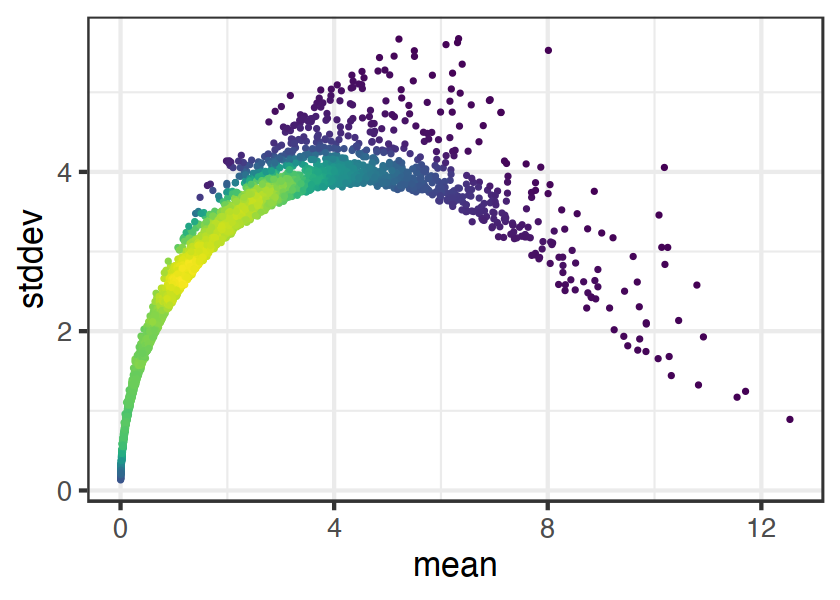

In [40]:
vargenes_means_sds[1:4,]
dim(vargenes_means_sds)

options(repr.plot.height = 5, repr.plot.width = 7)
ggplot(vargenes_means_sds, aes(mean, stddev)) +
         geom_pointdensity(size = 1) +
         scale_color_viridis() +
         theme_bw(base_size = 20) +
         theme(legend.position="none")

In [22]:
# Scale data
ref_exp_scaled <- singlecellmethods::scaleDataWithStats(exprs_norm, vargenes_means_sds$mean, 
                                                        vargenes_means_sds$stddev, 1)

In [32]:
# Run SVD, save gene loadings
s = irlba(ref_exp_scaled, nv = 20)
Z_pca_ref = diag(s$d) %*% t(s$v) # [pcs by cells]
loadings = s$u

In [33]:
# Gene loadings: genes x 20
dim(loadings)
loadings[1:4,]

# cell loadings: 20 x cell number
Z_pca_ref[1:4, ]

[1] 4018   20

0.01985158,-0.0368519680,0.015763533,0.025950048,0.03299841,-0.02408647,-0.030692594,-0.068684352,-0.0270433404,0.0002142081,0.0307534931,-0.008339845,-0.013390285,0.010976462,-0.041522629,0.016496641,0.019610620,-0.02658223,0.009063390,-0.01052113
-0.04219923,-0.0124910130,0.006031927,-0.016439509,-0.00145779,0.02533724,0.005133078,0.003875276,0.0014000036,-0.0085839262,-0.0002161497,-0.008176459,-0.005308038,0.008533037,0.008600394,-0.030238857,0.019292257,-0.02019541,-0.035768515,0.00813446
-0.02665044,-0.0002987321,0.014644359,0.005872108,-0.01569128,0.02298584,-0.047911351,0.018550956,-0.0281497431,0.0024019659,0.0093991783,0.060331884,0.008289782,-0.025073269,-0.012746978,0.002285817,0.004496328,0.03043406,-0.025656513,-0.01274029
-0.01592855,-0.0415583553,0.009351578,0.014630183,-0.01020819,-0.01571450,0.010366434,0.008492118,0.0001545373,0.0055380814,0.0020640026,0.004247509,-0.013554959,0.015679547,-0.009030066,0.004333065,0.007691353,-0.01626916,0.008674388,-0.02549413


17.431300,16.991601,16.462307,17.277624,15.890826,19.3737128,17.680652,18.656095,19.193323,14.691432,⋯,-21.6190423,-19.9944565,-24.451958,-20.22779059,-15.719631,-23.0623492,-21.3080259,-26.578967,-21.419143,-26.629915
7.786629,5.870682,6.145763,8.492837,5.576848,7.6978220,7.761225,7.139775,7.724756,7.025604,⋯,3.3142036,3.3764741,4.254285,3.16632560,4.155605,2.4585568,3.5763105,2.794519,2.976633,2.507538
-2.921360,-12.273559,-2.738627,-8.739382,-4.929457,0.7247058,-3.934976,-3.980498,4.759062,-12.693867,⋯,0.4975355,4.0086923,-1.662249,2.46076736,7.599219,2.1363431,0.6263362,-1.574493,4.299322,-2.621621
-6.291677,-5.848565,-4.664242,-5.982615,-7.132922,-9.4078465,-6.158140,-8.631500,-8.063924,-4.689477,⋯,0.1913002,0.3741912,1.979213,-0.08933466,-5.113858,-0.2330926,0.5693730,1.711507,-1.632276,1.096619


In [44]:
# Run Harmony
ref_harmObj = harmony::HarmonyMatrix(
        data_mat = t(Z_pca_ref), ## PCA embedding matrix of cells
        meta_data = meta_all, ## dataframe with cell labels
        theta = c(2), ## cluster diversity enforcement
        vars_use = c('plate'), ## variable to integrate out
        nclust = 200, ## number of clusters in Harmony model: use more cluster centroids to capture more subsets
        max.iter.harmony = 10,
        return_object = TRUE, ## return the full Harmony model object
        do_pca = FALSE ## don't recompute PCs
)

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony converged after 8 iterations



In [45]:
# buildReferenceFromHarmonyObj()
# Compress Harmony reference into a Symphony reference
reference = symphony::buildReferenceFromHarmonyObj(
                           ref_harmObj,            # output object from HarmonyMatrix()
                           meta_all,
                           vargenes_means_sds,     # gene names, means, and std devs for scaling
                           loadings,               # genes x PCs
                           verbose = TRUE,
                           do_umap = TRUE,         # Set to TRUE only when UMAP model was saved for reference
                           save_uwot_path = '2022_05_05_singlecell_RA_tutorial')

Save metadata, vargenes (S), and loadings (U)

Save R, Z_orig, Z_corr, and betas from Harmony object

Calculate final L2 normalized reference centroids (Y_cos)

Calculate reference compression terms (Nr and C)

UMAP

Saved uwot model

Finished nicely.



In [46]:
# Save reference
saveRDS(reference, '2022_05_05_singlecell_RA_tutorial_reference.rds')

In [ ]:
# Visualize

In [66]:
umap_labels <- cbind(reference$umap, reference$meta_data)
colnames(umap_labels)[1:2] <- c("UMAP1", "UMAP2")
umap_labels[1:4,]

,UMAP1,UMAP2,cell,barcode,sample,cell_type,disease,plate,lane,quadrant,⋯,molecules,genes_detected,percent_mt_molecules,percent_top10,cluster,gd,T1_all,T2_all,T1,T2
,<dbl>,<dbl>,<chr>,<fct>,<fct>,<fct>,<chr>,<fct>,<int>,<int>,⋯,<int>,<int>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
2,-4.712785,9.074711,S006_L1Q1_A03,ACTCGA,301-0159,T cell,OA,S006,1,1,⋯,2728,1239,0.1891496,0.1840176,SC-T1,1504,8.720527,-9.586673,5.727278,-1.287976
3,-2.353800,7.857561,S006_L1Q1_A05,AGTGCA,301-0159,T cell,OA,S006,1,1,⋯,4074,1673,0.2005400,0.2069219,SC-T4,1981,11.419902,-12.422794,4.859548,2.991211
4,-3.508826,9.457436,S006_L1Q1_A07,GTACAG,301-0159,T cell,OA,S006,1,1,⋯,2409,1305,0.1369863,0.1519303,SC-T1,1583,-1.143772,-14.887437,1.516363,4.621135
5,-5.258912,7.998123,S006_L1Q1_A09,ACGTAC,301-0159,T cell,OA,S006,1,1,⋯,3456,1607,0.1284722,0.1524884,SC-T1,1850,8.810839,-10.073524,5.819452,-1.214302


In [48]:
str(reference)

List of 12
 $ meta_data     :'data.frame':	5265 obs. of  40 variables:
  ..$ cell                       : chr [1:5265] "S006_L1Q1_A03" "S006_L1Q1_A05" "S006_L1Q1_A07" "S006_L1Q1_A09" ...
  ..$ barcode                    : Factor w/ 96 levels "ACAGAC","ACAGGA",..: 11 23 61 7 47 22 31 70 92 62 ...
  ..$ sample                     : Factor w/ 26 levels "300-0122","300-0153",..: 21 21 21 21 21 21 21 21 21 21 ...
  ..$ cell_type                  : Factor w/ 5 levels "B cell","Empty",..: 5 5 5 5 5 5 5 5 5 5 ...
  ..$ disease                    : chr [1:5265] "OA" "OA" "OA" "OA" ...
  ..$ plate                      : Factor w/ 27 levels "S006","S008",..: 1 1 1 1 1 1 1 1 1 1 ...
  ..$ lane                       : int [1:5265] 1 1 1 1 1 1 1 1 1 1 ...
  ..$ quadrant                   : int [1:5265] 1 1 1 1 1 1 1 1 1 1 ...
  ..$ well384                    : Factor w/ 384 levels "A01","A02","A03",..: 3 5 7 9 11 15 17 19 23 55 ...
  ..$ picard_pf_bases            : int [1:5265] 5769143 8005673 6495

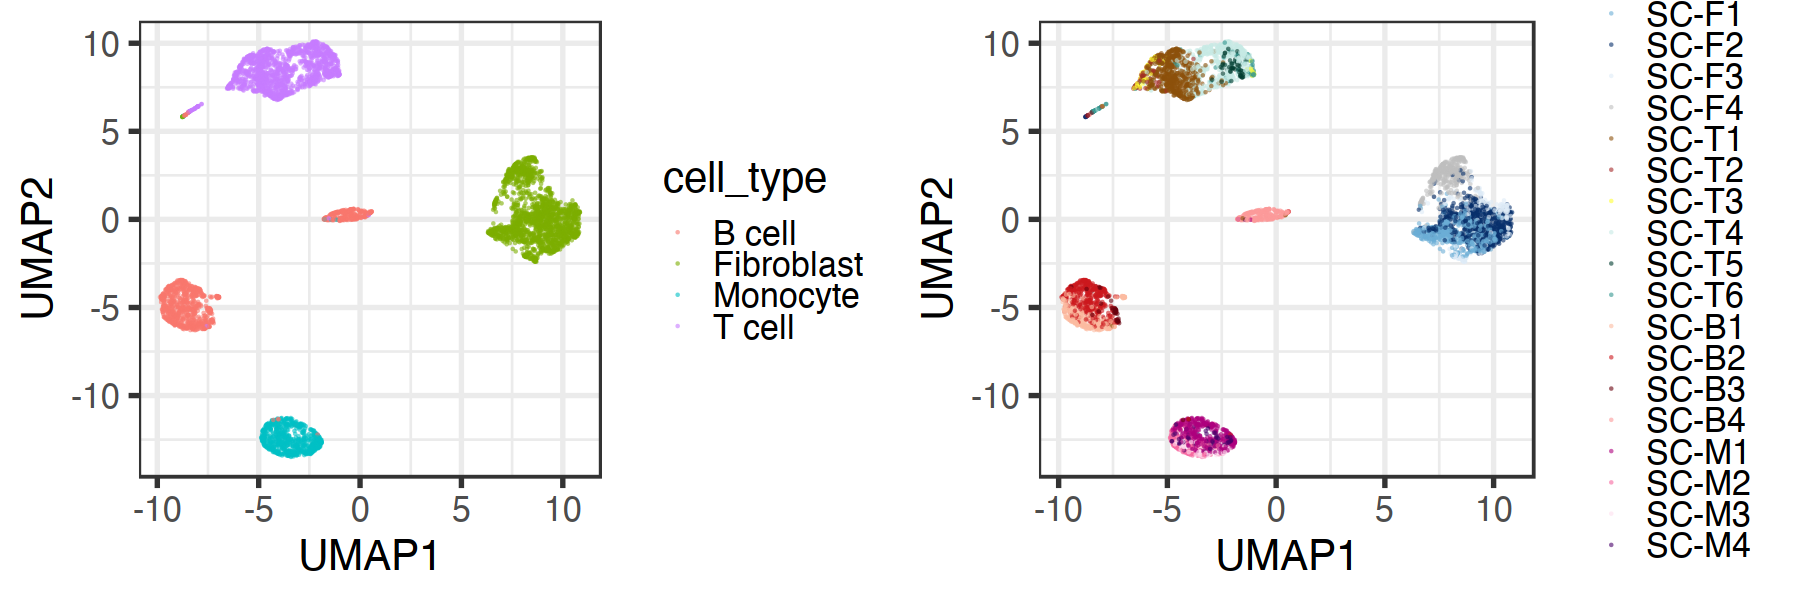

In [67]:
p1 <- ggplot(umap_labels,
       aes(x = UMAP1, y = UMAP2, fill= cell_type)
              ) +
       # geom_hex(bins = 150) +
       geom_point(size = 1, stroke = 0.0001, shape = 21, alpha = 0.6) +
       # scale_fill_manual(values = meta_colors$cluster, name = "") +
       theme_bw(base_size = 25) 


p2 <- ggplot(umap_labels,
       aes(x = UMAP1, y = UMAP2, fill= cluster)
              ) +
       # geom_hex(bins = 150) +
       geom_point(size = 1, stroke = 0.0001, shape = 21, alpha = 0.6) +
       scale_fill_manual(values = meta_colors$cluster, name = "") +
       theme_bw(base_size = 25) 

options(repr.plot.height = 5, repr.plot.width = 15)
plot_grid(p1, p2, nrow = 1)



In [87]:
# Get centroid
cluster_sizes = reference$cache[[1]] %>% as.matrix()
centroid_sums = t(reference$Z_corr %*% t(reference$R)) %>% as.data.frame()
centroids = sweep(centroid_sums, 1, cluster_sizes, "/")
colnames(centroids) = paste0("hPC", c(1:20))
dim(centroids)

ref_umap_model = uwot::load_uwot(reference$save_uwot_path, verbose = FALSE)
umap_centroids = uwot::umap_transform(centroids, ref_umap_model)
umap_centroids <- as.data.frame(umap_centroids)
colnames(umap_centroids) <- c("UMAP1", "UMAP2")
umap_centroids$cell <- rep("NA", nrow(umap_centroids))
umap_centroids$cell_type <- rep("NA", nrow(umap_centroids))
umap_centroids$disease <- rep("NA", nrow(umap_centroids))
umap_centroids$sample <- rep("NA", nrow(umap_centroids))
umap_centroids$plate <- rep("NA", nrow(umap_centroids))
umap_centroids$cluster <- rep("Centroid", nrow(umap_centroids))
umap_centroids[1:4,]
dim(umap_centroids)

[1] 200  20

,UMAP1,UMAP2,cell,cell_type,disease,sample,plate,cluster
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,-8.444683,-5.5185680,NA,NA,NA,NA,NA,Centroid
2,-0.298199,0.1521674,NA,NA,NA,NA,NA,Centroid
3,-8.870077,-4.6411295,NA,NA,NA,NA,NA,Centroid
4,7.964797,2.7972679,NA,NA,NA,NA,NA,Centroid


[1] 200   8

In [90]:
umap_labels_centroid <- rbind(umap_labels[, c('UMAP1', 'UMAP2','cell', "cell_type", "cluster", "disease", "sample", "plate")], umap_centroids)
table(umap_labels_centroid$cluster)


Centroid    SC-B1    SC-B2    SC-B3    SC-B4    SC-F1    SC-F2    SC-F3 
     200      355      440       48      299      484      719      228 
   SC-F4    SC-M1    SC-M2    SC-M3    SC-M4    SC-T1    SC-T2    SC-T3 
     413      349      237       93       71      635       48       70 
   SC-T4    SC-T5    SC-T6 
     603       63      110 

$`1`

$`2`

attr(,"class")
[1] "list"      "ggarrange"

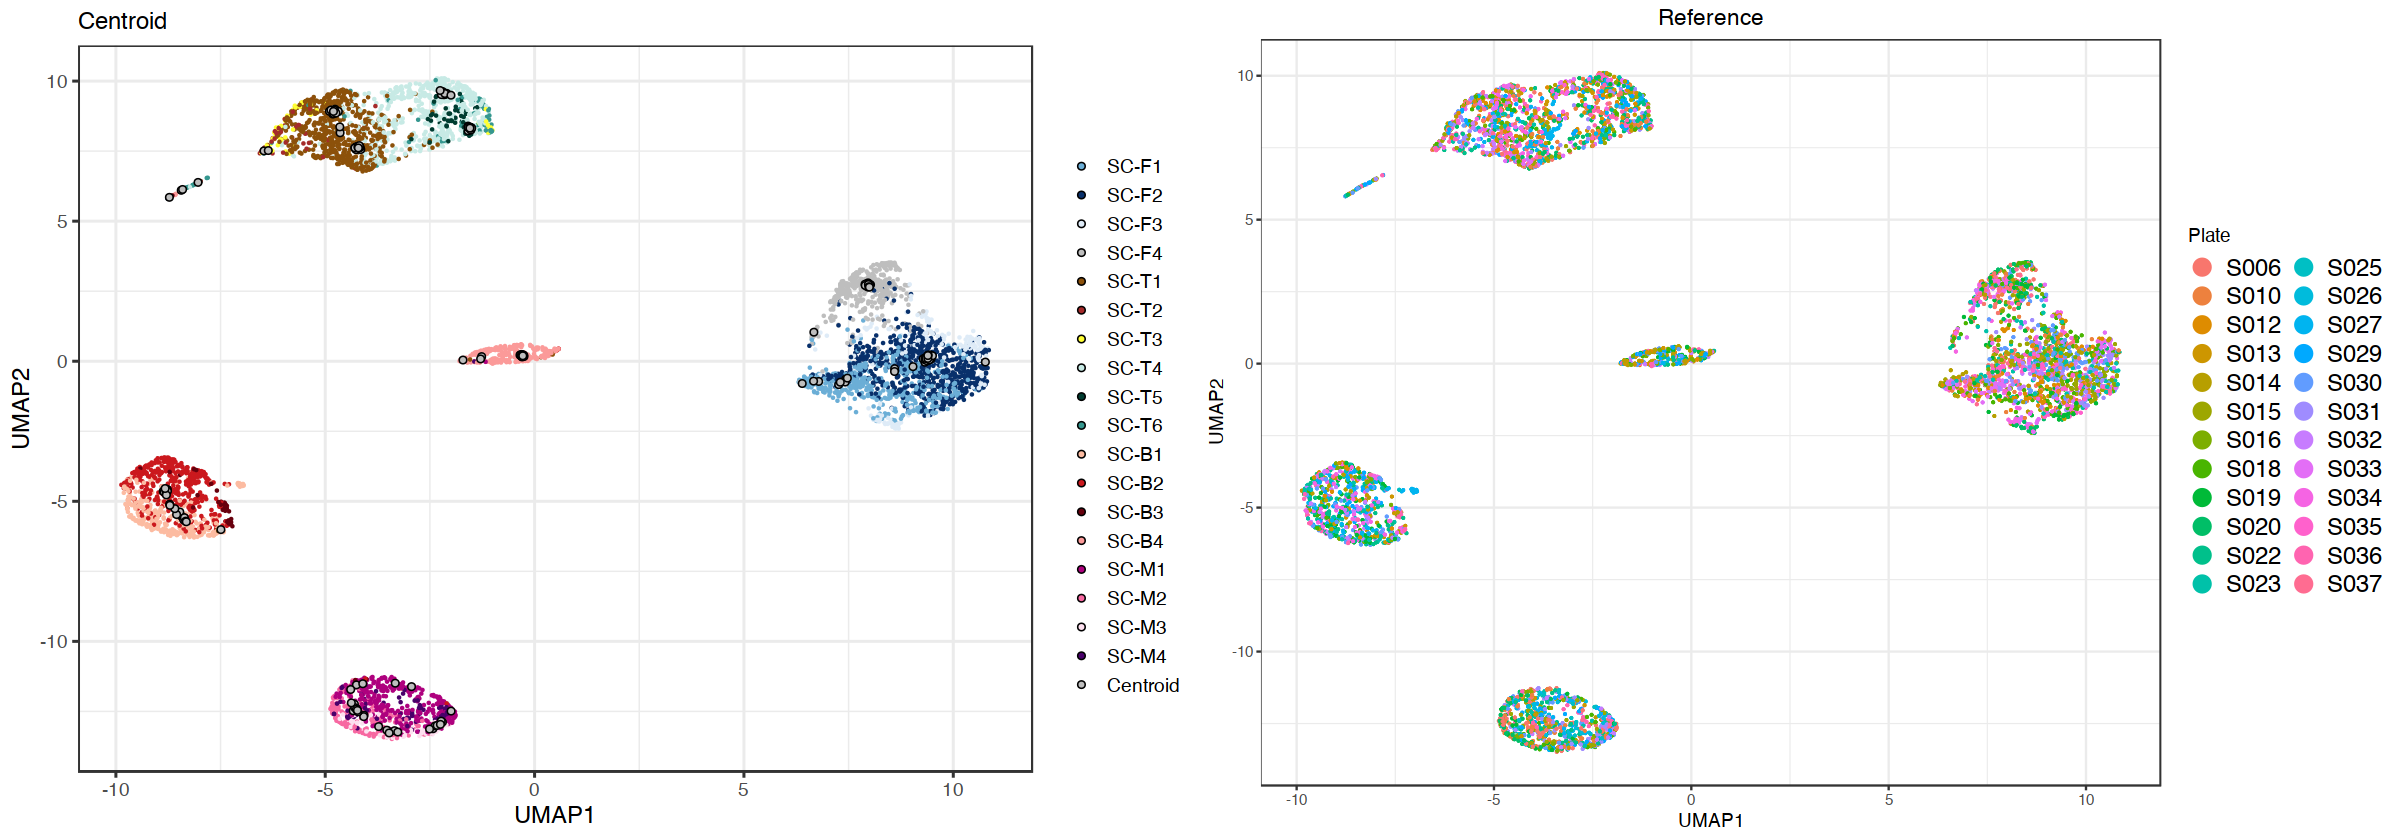

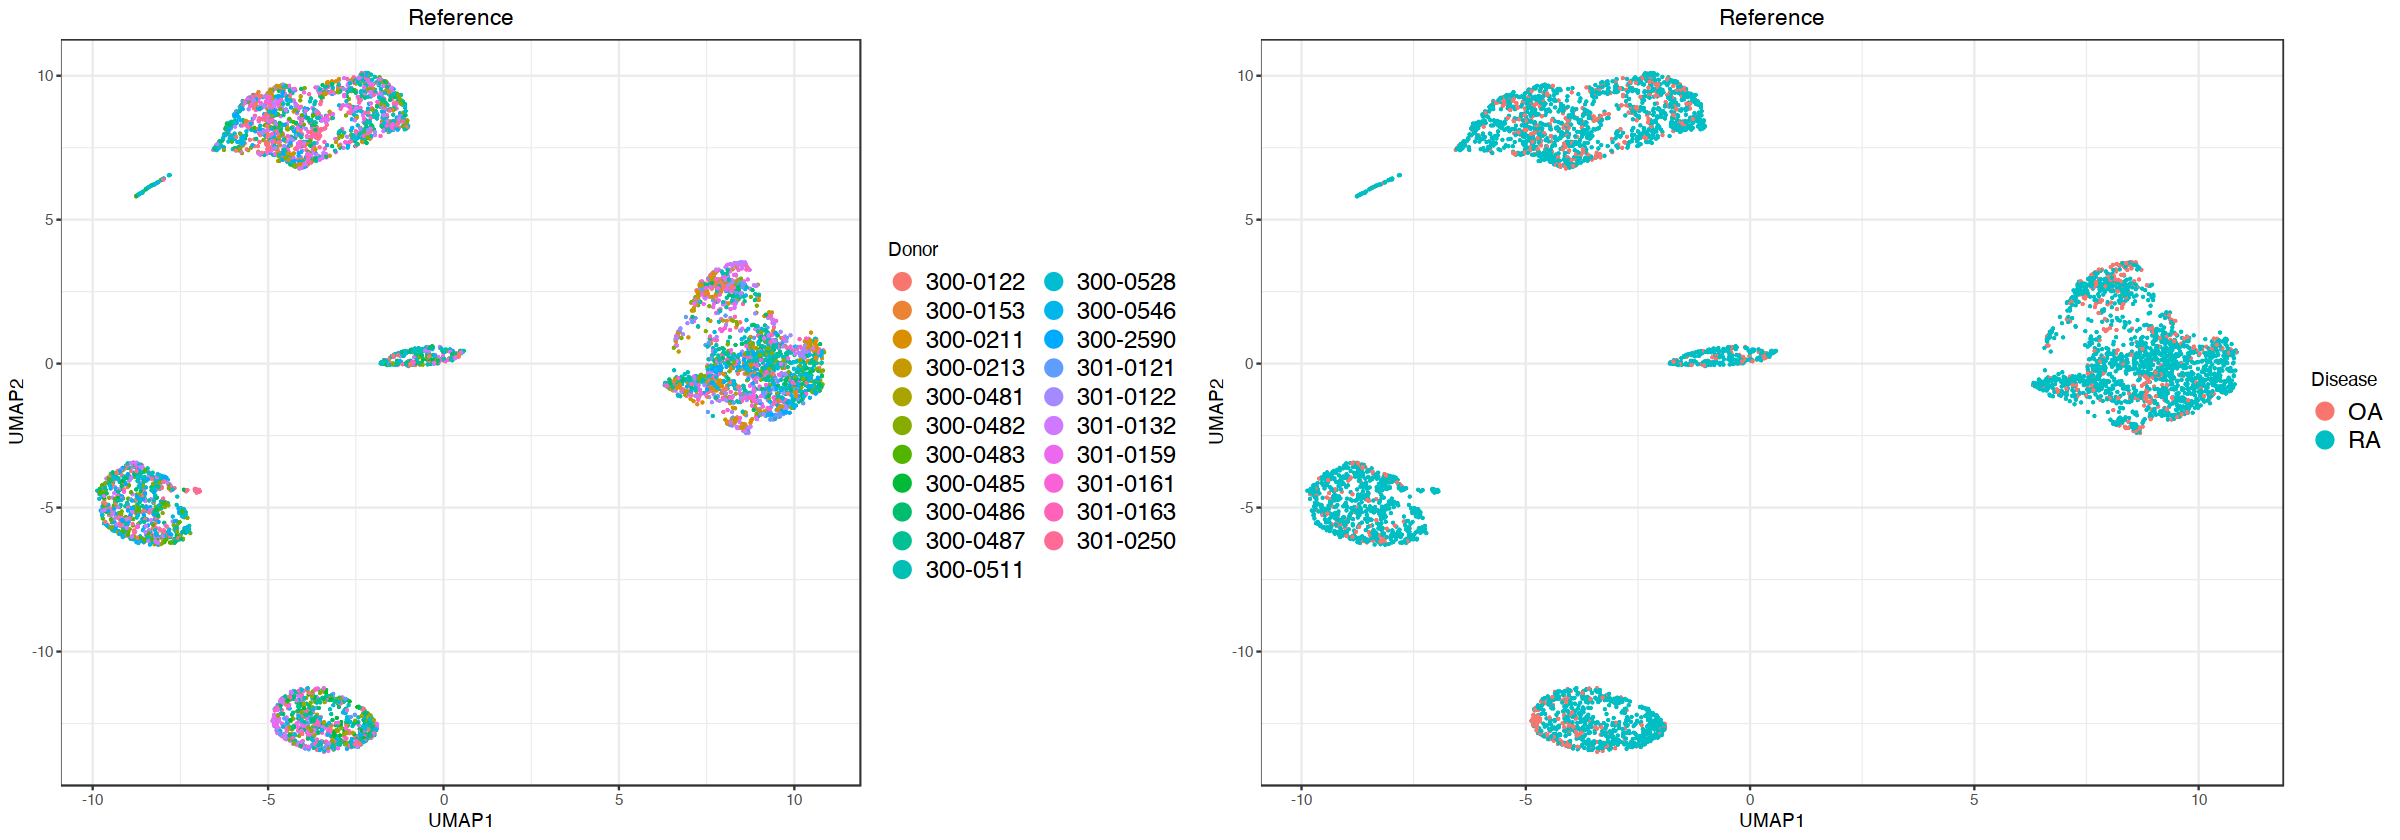

In [192]:
fig.size(4, 6)

p0 <- ggplot() +
  geom_point(
    data = umap_labels_centroid[which(umap_labels_centroid$cluster != "Centroid"),],
    mapping = aes_string(x = "UMAP1", y = "UMAP2", fill = "cluster"),
    size = 1, stroke = 0.01, shape = 21
  ) +
  geom_point(
    data = umap_labels_centroid[which(umap_labels_centroid$cluster == "Centroid"),],
    mapping = aes_string(x = "UMAP1", y = "UMAP2", fill = "cluster"),
    size = 1.5, stroke = 0.5, shape = 21
  ) +
  scale_fill_manual(values = meta_colors$cluster, name = "") +
  guides(colour = guide_legend(override.aes = list(size = 10))) +
  labs(title = 'Centroid') + 
  theme_bw(base_size = 14) +
  theme(
#     legend.position = "none",
    plot.title = element_text(color="black", size=14)
  ) 



p1 <- umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = plate)) +
    geom_point_rast(size = 1, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Reference', color = 'Plate') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    # scale_color_manual(values=meta_colors$cluster) +
    theme(legend.position="right") +
    theme(legend.text = element_text(size=14)) +
    guides(colour = guide_legend(override.aes = list(size = 5)))


p2 <- umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = sample)) +
    geom_point_rast(size = 1, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Reference', color = 'Donor') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    # scale_color_manual(values=meta_colors$cluster) +
    theme(legend.position="right") +
    theme(legend.text = element_text(size=14)) +
    guides(colour = guide_legend(override.aes = list(size = 5)))


p3 <- umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = disease)) +
    geom_point_rast(size = 1, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Reference', color = 'Disease') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    # scale_color_manual(values=meta_colors$cluster) +
    theme(legend.position="right") +
    theme(legend.text = element_text(size=14)) +
    guides(colour = guide_legend(override.aes = list(size = 5)))

options(repr.plot.height =7, repr.plot.width = 20)
ggarrange(p0, p1, p2, p3, ncol = 2, vjust = 1)

In [165]:
# Louvain on harmonized PCs
snn_pcs <- BuildSNNSeurat(t(reference$Z_corr), nn.eps = .5)
                                 
# Use different resolutions for clustering
resolution_list <- c(0.3, 0.9, 1.2)
ids_cos <- Reduce(cbind, mclapply(resolution_list, function(res_use) {
    Seurat:::RunModularityClustering(SNN = snn_pcs, modularity = 1, 
        resolution = res_use, algorithm = 3, n.start = 10, 
        n.iter = 10, random.seed = 0, print.output = FALSE, 
        temp.file.location = NULL, edge.file.name = NULL)    
}, mc.cores = min(16, length(resolution_list))))
ids_cos %<>% data.frame()
colnames(ids_cos) <- sprintf("res_%.2f", resolution_list)

names(ids_cos)
umap_labels$res_0.30 <- as.character(ids_cos$res_0.30)
umap_labels$res_0.90 <- as.character(ids_cos$res_0.90)
umap_labels$res_1.20 <- as.character(ids_cos$res_1.20)

[1] "res_0.30" "res_0.90" "res_1.20"

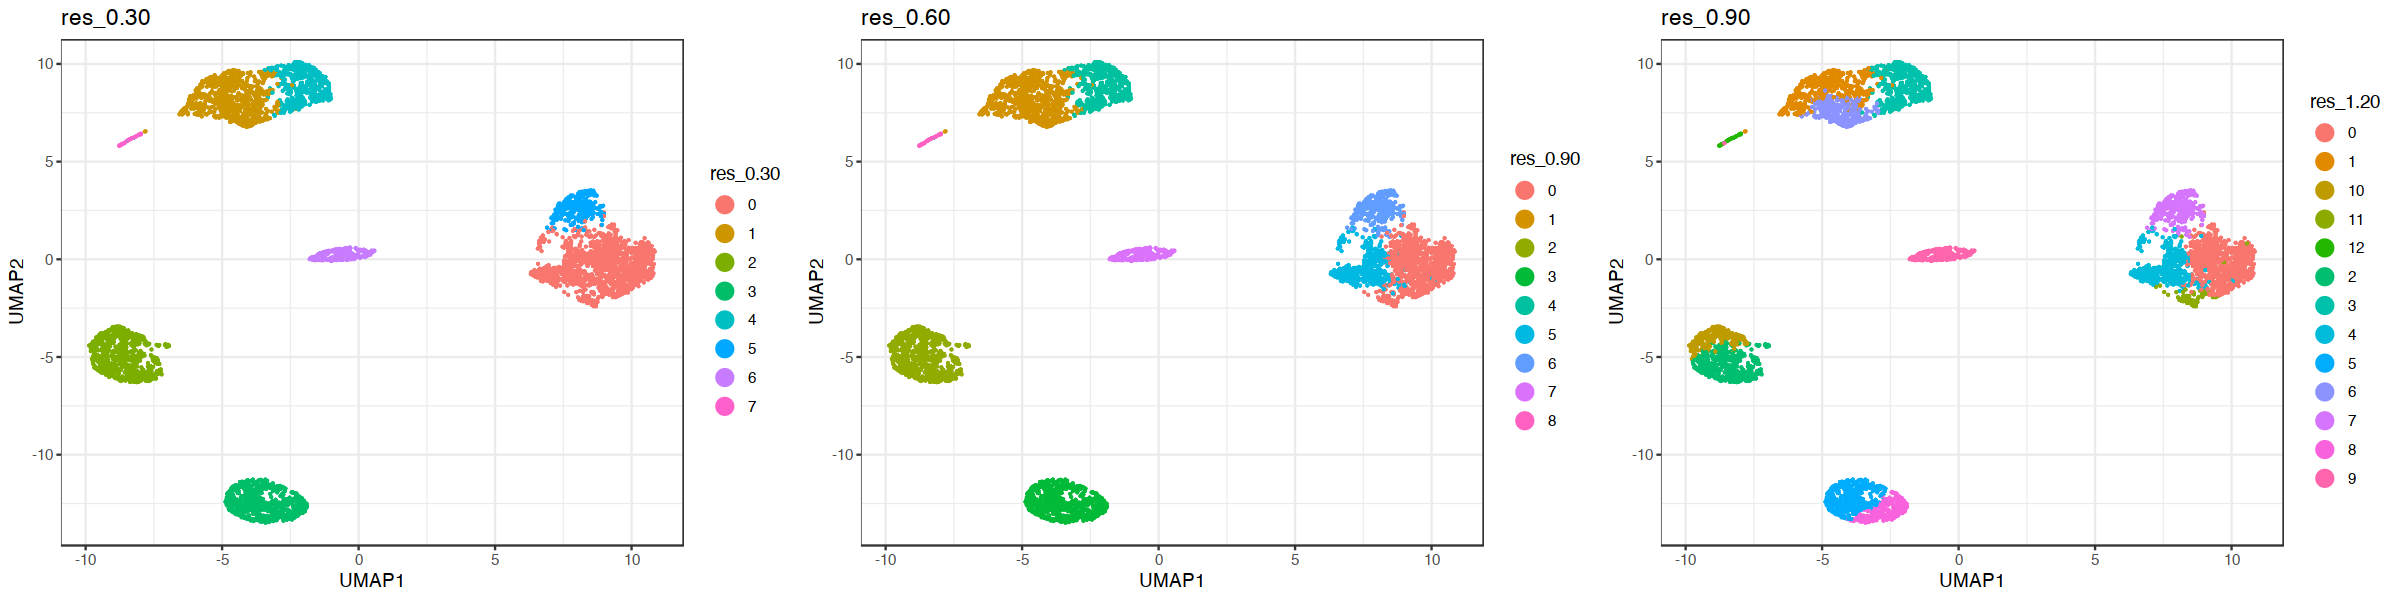

In [176]:
p1 <- umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = res_0.30)) +
    geom_point_rast(size = 1, stroke = 0.2, shape = 16) +
    labs(title = 'res_0.30') + 
    theme_bw() +
    guides(colour = guide_legend(override.aes = list(size = 5)))


p2 <- umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = res_0.90)) +
    geom_point_rast(size = 1, stroke = 0.2, shape = 16) +
    labs(title = 'res_0.60') + 
    theme_bw() +
    guides(colour = guide_legend(override.aes = list(size = 5)))


p3 <- umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = res_1.20)) +
    geom_point_rast(size = 1, stroke = 0.2, shape = 16) +
    labs(title = 'res_0.90') + 
    theme_bw() +
    guides(colour = guide_legend(override.aes = list(size = 5)))

options(repr.plot.height =5, repr.plot.width = 20)
ggarrange(p1, p2, p3, ncol = 3, vjust = 1)

In [16]:
length(intersect(var_genes, rownames(genesets_rowscale)))
mRNA_scale <- singlecellmethods::scaleData(exprs_norm[intersect(var_genes, rownames(genesets_rowscale)), ])
# genesets_scale <- genesets_scale[intersect(var_genes, rownames(genesets_scale)),]
genesets_rowscale <- genesets_rowscale[intersect(var_genes, rownames(genesets_rowscale)),]

dim(mRNA_scale)
# dim(genesets_scale)
dim(genesets_rowscale)

[1] 8468 5265

[1]  8468 11988

In [17]:
all(rownames(mRNA_scale) == rownames(genesets_rowscale))

[1] TRUE

In [19]:
z <- gzfile("gene_pathway_rowscale_8468genesrows_11988pathways.csv.gz")
write.csv(genesets_rowscale, z)

In [13]:
# Add a Gaussian noise to the  matrix
 Noisify <- function(data) {
            if (is.vector(data)) {
                         noise <- runif(length(data), -0.0001, 0.0001)
     noisified <- data + noise
        } else {
                     length <- dim(data)[1] * dim(data)[2]
          noise <- matrix(runif(length, -0.0001, 0.0001), dim(data)[1])
               noisified <- data + noise
             }
   return(noisified)
    }

genesets_scale_noise <- Noisify(genesets_scale)
genesets_scale_noise[1:4,1:4]

,HALLMARK_ADIPOGENESIS,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANGIOGENESIS
CD74,-0.08650093,4.09278494,-0.06221545,-0.03776196
FN1,-0.08642509,-0.05478792,-0.06231581,-0.03760547
FTL,-0.08650804,-0.05472199,-0.06219668,-0.03769016
NEAT1,-0.08637987,-0.05475896,-0.06223452,-0.03767308


In [14]:
dim(genesets_scale)
dim(genesets_scale_noise)

[1]  8468 11988

[1]  8468 11988

In [15]:
# Save data for running DCCAE in another notebook
z <- gzfile("mRNA_scale_8468genesrows_5265cells.csv.gz")
write.csv(mRNA_scale, z)

z <- gzfile("gene_pathway_scale_8468genesrows_11988pathways.csv.gz")
write.csv(genesets_scale, z)

z <- gzfile("gene_pathway_scale_noise_8468genesrows_11988pathways.csv.gz")
write.csv(genesets_scale_noise, z)

In [ ]:
# Load the data
# mRNA_scale <- fread("mRNA_scale_8305genesrows_5265cells.csv.gz")
# gene_pathway <- fread("gene_pathway_8305genesrows_4872pathways.csv.gz")

In [16]:
meta_all <- data.frame(
    gene = rownames(mRNA_scale)
    )
dim(meta_all)
meta_all[1:4,]

write.table(meta_all, file='meta_mRNA_8468genes.tsv', quote=FALSE, sep='\t', col.names = NA)
write.table(meta_all, file='meta_pathway_8468genes.tsv', quote=FALSE, sep='\t', col.names = NA)

[1] 8468    1

[1] "CD74"  "FN1"   "FTL"   "NEAT1"